<h1><center>Airplane Crash Data Analysis </center></h1>

## Problem Statement

The "Airplane crash data analysis" analyses the data of airplane crashes over 100 years beginning from 1908 to 2009.It is interesting to observe the pattern and reason for the airplane crashes.As air transportation is the basic medium nowadays,it is important to avoid the future crashes. By exploring the past patterns we can find ways to overcome crashes that might happen in the future. 

## Dataset

The dataset is taken from the Kaggle-https://www.kaggle.com/saurograndi/airplane-crashes-since-1908
In this dataset consists of 5268 observations of 13 variables. They are
* Date
* Time
* Location
* Operator 
* Flight
* Route
* Type
* Registration
* cn.ln
* Abroad
* Fatalities
* Ground
* Summary

# Goal

In this Airplane Crash Data Analysis the goal is to achieve the following:
* Total number of plane crash in a year
* Total number of people aboard the flight, number of people survived in flight and fatalities occured.
* Highest number of crashes by individual operators.
* Most Dangerous City for Departure and Destination¶



In [20]:
from __future__ import division
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import textblob
import re
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import naive_bayes
sns.set(style="whitegrid")
sns.set_color_codes("pastel")
import datetime
%matplotlib inline

In [12]:
#Read the data into the data frame
df = pd.read_csv("Airplane_Crashes_and_Fatalities_Since_1908.csv",low_memory=False)

In [19]:
df.head()

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,7/12/1912,6:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [5]:
#The coloumns and their respective datatypes of the dataset
df.dtypes

Date             object
Time             object
Location         object
Operator         object
Flight #         object
Route            object
Type             object
Registration     object
cn/In            object
Aboard          float64
Fatalities      float64
Ground          float64
Summary          object
dtype: object

In [6]:
#Handling of missing values for better analysis
null_ind = []
null_val = []
for col in df.columns:
    null_ind.append(col + " % null : ")
    try: 
        value = (pd.isnull(df[col]).value_counts()[True]/df.shape[0])*100
    except:
        value = 0
    null_val.append(round(value,3))
    
null_table = pd.Series(null_val,index=null_ind)
null_table.sort_values()

Date % null :              0.000
Fatalities % null :        0.228
Operator % null :          0.342
Location % null :          0.380
Aboard % null :            0.418
Ground % null :            0.418
Type % null :              0.513
Registration % null :      6.359
Summary % null :           7.403
cn/In % null :            23.311
Route % null :            32.384
Time % null :             42.122
Flight # % null :         79.708
dtype: float64

In [7]:
# Exploratory Data Analysis to understand numerical coloumns of the dataset
df.describe()

,Aboard,Fatalities,Ground
count,5246.000000,5256.000000,5246.000000
mean,27.554518,20.068303,1.608845
std,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


### Total number of plane crash in a year

In [8]:
# converting of "Date" column datatype from string type to datetime format
df["Date"] = pd.to_datetime(df["Date"])

# converting of "Time" column datatype from string to datetime format

def make_datetime(x):
    try: 
        return datetime.datetime.strptime(x, '%H:%M').time()
    except:
        return np.nan

df["Time"] = df["Time"].apply(make_datetime)

In [9]:
# Extracting the year, month and day out of the Date column
df["Year"] = df["Date"].apply(lambda x: x.year)
months = ["January","February","March","April","May", "June", "July","August","September","October","November","December"]
df["Month"] = df["Date"].apply(lambda x: x.month)
df["Day"] = df["Date"].apply(lambda x: x.day)

# dropping null columns for this analysis
df_time = df.dropna(subset=["Time"])

# Extracting the hour out of the time column
df_time["Hour"] = df_time["Time"].apply(lambda x: x.hour)

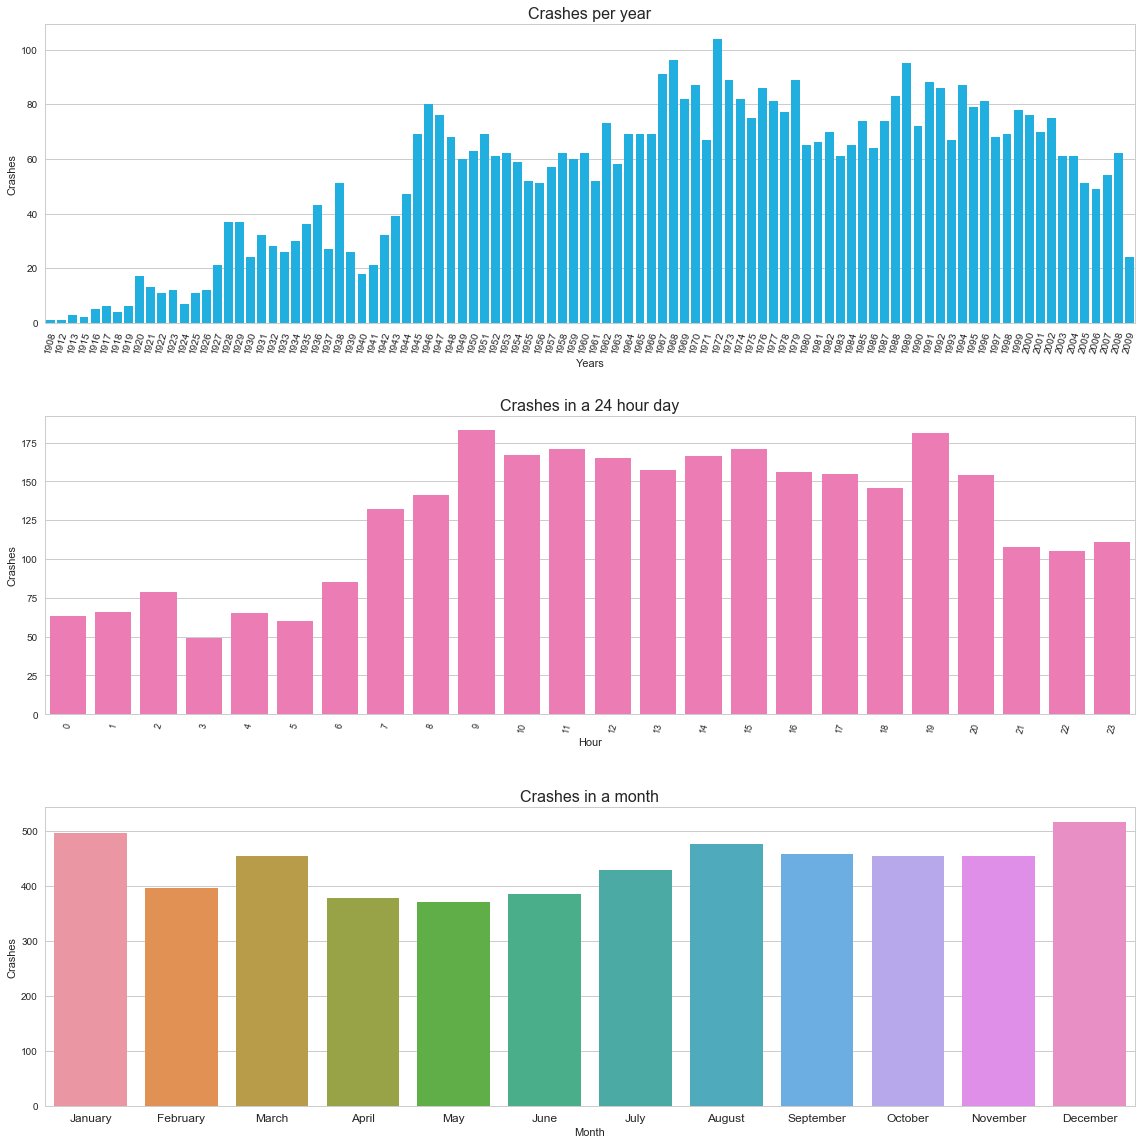

In [10]:
df_year = df["Year"].value_counts().sort_index()
df_hour = df_time["Hour"].value_counts().sort_index()
df_month = df["Month"].value_counts().sort_index()

figure = plt.figure(figsize=(16,16))
axis1 = figure.add_subplot(3,1,1)
sns.barplot(x=df_year.index,y=df_year.values,ax=axis1,color='deepskyblue')
axis1.set(ylabel="Crashes",xlabel="Years")
axis1.set_title("Crashes per year",fontsize=16)
axis1.set_xticklabels(df_year.index,rotation=75,fontsize=10)


axis2 = figure.add_subplot(3,1,2)
sns.barplot(x=df_hour.index,y=df_hour.values,ax=axis2,color='hotpink')
axis2.set(ylabel="Crashes",xlabel="Hour")
axis2.set_title("Crashes in a 24 hour day",fontsize=16)
axis2.set_xticklabels(df_hour.index,rotation=75,fontsize=9)

axis3 = figure.add_subplot(3,1,3)
sns.barplot(x=df_month.index,y=df_month.values,ax=axis3)
axis3.set(ylabel="Crashes",xlabel="Month")
axis3.set_title("Crashes in a month",fontsize=16)
axis3.set_xticklabels(months,fontsize=12)


plt.tight_layout(w_pad=4, h_pad=3)
plt.show()

### **Total number of people aboard the flight, number of people survived in flight and fatalities occured**

In [25]:
# dropping null values from the columns Aboard and Fatalities and check if there exist any outliers like 
# fatalities being greater than aboard
df[["Aboard","Fatalities"]].dropna()[df["Fatalities"] > df["Aboard"]]

C:\Users\prach\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


,Aboard,Fatalities


In [26]:
# calculating the number of survivors
df["Survivors"] = df["Aboard"] - df["Fatalities"]
# calculating the total number of survived and fatalaties for each year
aboard_fatalities = df.pivot_table(values=["Survivors","Fatalities"],index="Year",aggfunc=np.sum)
aboard_fatalities.head()

,Fatalities,Survivors
Year,,
1908,1.0,1.0
1912,5.0,0.0
1913,45.0,6.0
1915,40.0,20.0
1916,108.0,1.0


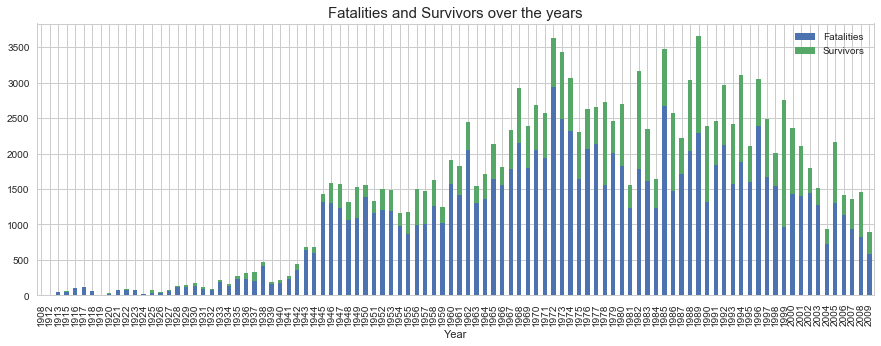

In [34]:
figure = plt.figure(figsize=(15,5))
axis = figure.add_subplot(1,1,1)
aboard_fatalities.plot(kind="bar",stacked=True,ax=axis)
plt.title("Fatalities and Survivors over the years",fontsize=15)
axis1.set_xticklabels(aboard_fatalities,fontsize=12)
plt.show()

### Highest number of crashes by individual operators

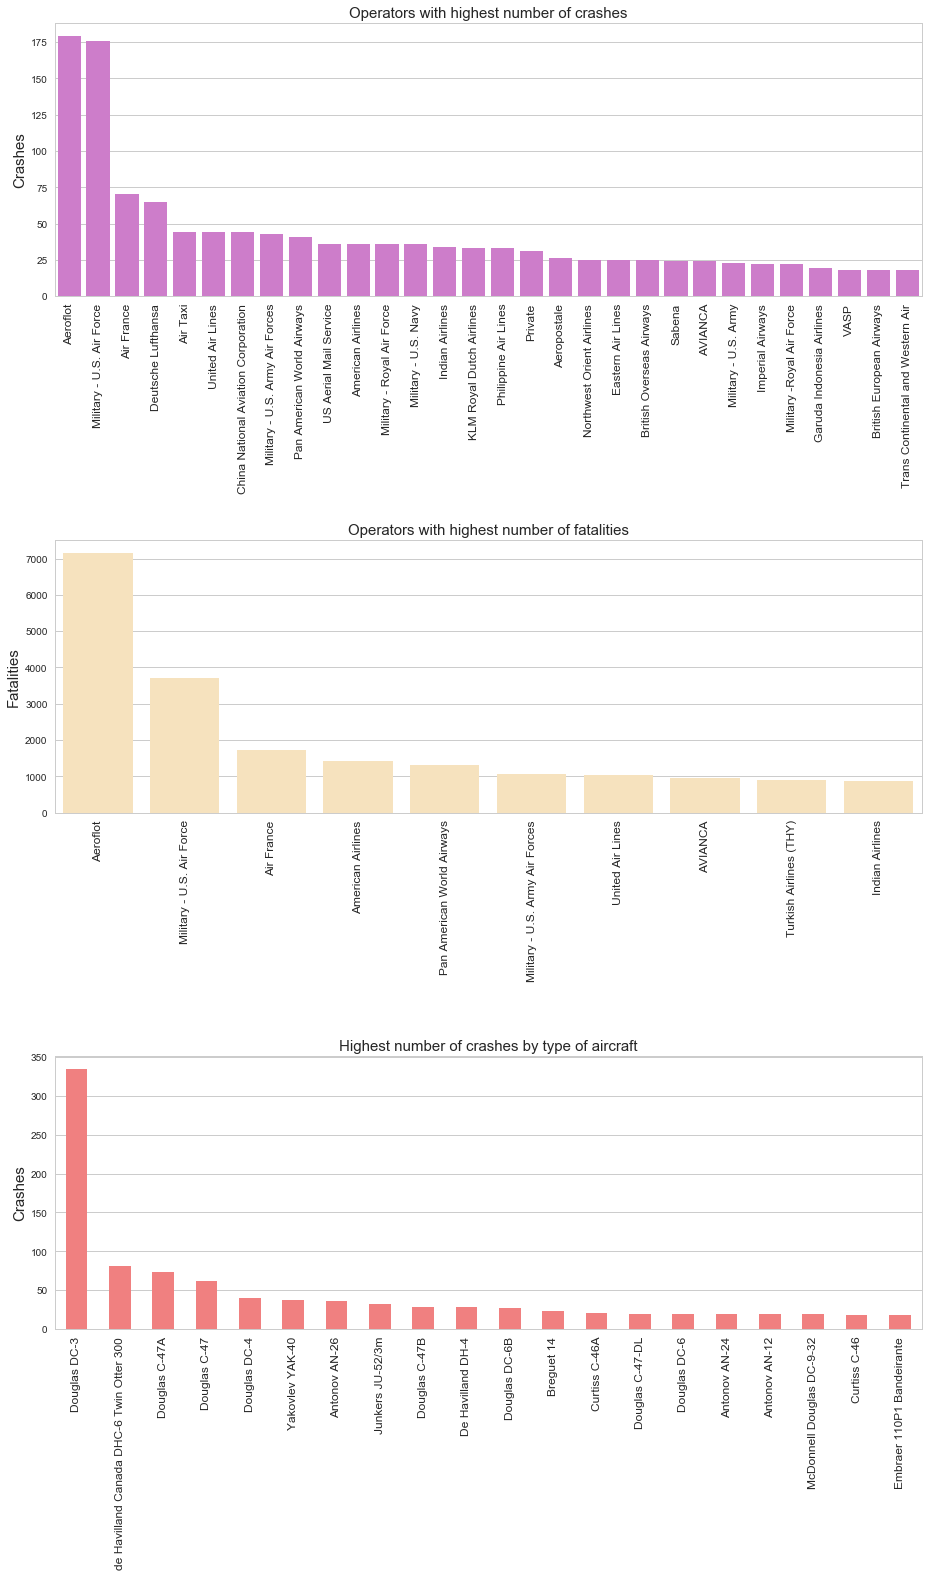

In [49]:
# operators with highest number of fatalities
top_df = df.pivot_table(values="Fatalities",index="Operator",aggfunc=np.sum).sort_values(ascending=False).head(10)

figure = plt.figure(figsize=(13,22))

# plotting the operators with highest number of crashes
axis1 = figure.add_subplot(3,1,1)
sns.barplot(x=df["Operator"].value_counts().head(30).index,y=df["Operator"].value_counts().head(30).values,ax=axis1,
            color='orchid')
axis1.set_ylabel("Crashes",fontsize=15)
axis1.set_xticklabels(df["Operator"].value_counts().head(30).index,rotation=90,fontsize=12)
axis1.set_title("Operators with highest number of crashes",fontsize=15)

#plotting the operators with highest number of fatalities
axis2 = figure.add_subplot(3,1,2)
sns.barplot(x=top_df.index,y=top_df.values,ax=axis2,color='moccasin')
axis2.set_ylabel("Fatalities",fontsize=15)
axis2.set_xlabel("")
axis2.set_xticklabels(top_df.index,rotation=90,fontsize=12)
axis2.set_title("Operators with highest number of fatalities",fontsize=15)

# plotting aircrafts with highest number of crashes
axis3 = figure.add_subplot(3,1,3)
df["Type"].value_counts().head(20).plot(kind='bar',color='lightcoral',ax=axis3)
axis3.set_ylabel("Crashes",fontsize=15)
axis3.set_xticklabels(df["Type"].value_counts().head(20).index,rotation=90,fontsize=12)
axis3.xaxis.grid(False)
axis3.set_title("Highest number of crashes by type of aircraft",fontsize=15)


plt.tight_layout(w_pad=4, h_pad=3)
plt.show()

In [64]:
#Word frequency analysis
import textblob
stringText = textblob.TextBlob(str(list(df["Summary"]))).lower()
words = stringText.words

In [65]:
wordCount = {}
ignore = ['a', 'an', 'the', "'the", 'and', 'to', 'of', 'in', 'into', 'is', 'was', 'on', 'at', 'from', 'with',
          'while', 'for', "'s", 'as', 'not', 'by', 'after', 'during']

for word in words:
    if word in ignore:
        continue
    if word in wordCount:
        wordCount[word] = wordCount[word] + 1
    else:
        wordCount[word] = 1

In [66]:
import operator
sorted_word = sorted(wordCount.items(), key=operator.itemgetter(1), reverse=True)[:500]
with open("sorted_wordcount.txt", "w") as f:f.write(str(sorted_word))

In [50]:
operator = df[["Operator","Fatalities"]].groupby("Operator").agg(["sum","count"])
operator

Fatalities      
                                              sum count
Operator                                               
A B Aerotransport                             3.0     2
AB Aerotransport                             58.0     3
ACES Colombia                                40.0     3
ADC Airlines                                 97.0     2
ADES Colombia                                22.0     2
AECA Cargo                                    4.0     1
AIDA                                         14.0     1
AIRES Colombia                               27.0     2
ALADA                                        16.0     1
ALFA                                         18.0     1
ALIANSA Colombia                              8.0     1
ANDESA                                       30.0     1
ANT Air Taxi                                  5.0     1
APRL                                         11.0     1
AREA                                         69.0     2
ARTOP Aerotopografica LDA                    36.0     1
ATESA                                         5.0     1
ATI                                           6.0     2
ATI Aircompany                                8.0     1
AV Air / American Eagle                      12.0     1
AVCOM                                         2.0     1
AVENSA                                        2.0     1
AVIANCA                                     941.0    24
AVIANCA / AVIANCA                            38.0     1
AVISPA                                       40.0     1
AZAL Cargo Company                            7.0     1
Aaxico Airlines                               9.0     3
Ababeel Aviaition                             4.0     1
Abakan Airlines                               3.0     1
Aca-Ancargo                                  44.0     1
...                                           ...   ...
Win Win Aviation                              1.0     1
Winchester Air                                5.0     1
Winged Cargo Inc.                             7.0     1
Wings West Airlines / Private                17.0     1
Winship Air                                   6.0     1
Winship Air Service                           6.0     1
Winship Air Service - Air Taxi                2.0     1
World Airways                                88.0     3
Wrangell Air Service                          1.0     1
Wright Air Service - Air Taxi                 3.0     1
Wuhan Airlines                               58.0     2
Wyman Pilot Service - Air Taxi                2.0     1
Wyoming Air Service                           1.0     1
XL Airways leased from Air New Zealand        7.0     1
YPF                                           7.0     1
YPFB Transportes Aereos                      14.0     1
Yacimientos Petroliferos Fiscales            34.0     1
Yakutavia                                    17.0     2
Yates Aviation                                1.0     1
Yemen Airlines                               13.0     2
Yeti Airlines                                30.0     3
Yug Avia                                      4.0     1
Yute Air Alaska - Air Taxi                    5.0     2
Zakavia                                       5.0     1
Zanex                                         1.0     1
Zantop Air Transport                         13.0     4
Zantop Airways                                2.0     1
Zantop International Airlines                 4.0     1
Zen Nippon                                    2.0     1
de Havilland Aircraft                        11.0     1

[2476 rows x 2 columns]

In [67]:
#6 Major Reasons of Airplane Crash After complete analysis of sorted_wordcount.txt and word frequency
reasons = ['weather', 'fire', 'shot down', 'stall/runway', 'pilot/crew error', 'systems failure']


In [68]:
expresion = ['((poor|bad).*(weather|visibility)|thunderstorm|fog)','(caught fire)|(caught on fire)', 
           '(shot down) | (terrorist) | (terrorism)', '(stall)|(runway)', '(pilot|crew) (error|fatigue)',
            '(engine.*(fire|fail))|(structural fail)|(fuel leak)|(langing gear)|(turbulence)|(electrical)|(out of fuel)|(fuel.*exhaust)']

In [69]:
df['Label'] = pd.Series(np.nan, index=df.index)
df.head(1)

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,Year,Month,Day,Survivors,Label
0,1908-09-17,17:18:00,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908,9,17,1.0,NaN


In [70]:
#Creation of train dataset
trainData = []
for x in range(len(df)):
    if df.loc[x,"Summary"] is np.nan:
        df.loc[x,"Label"] = "unknown"
    else:
        for y in range(len(expresion)):
            if re.search(expresion[y], df.loc[x,"Summary"].lower()):
                df.loc[x,"Label"] = reasons[y]
                temp = df.loc[x,"Summary"].lower(), df.loc[x,"Label"]
                trainData.append(temp)
                break

In [72]:
#building of Naive Bayes Classifer
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(trainData)

In [73]:
reasons.append("unknown")
for x in range(30,len(df)):
    if df.loc[x,"Label"] in reasons:
       continue
    else:
        df.loc[x,"Label"] = cl.classify(df.loc[x,"Summary"])

### **Airplane Crashes by Label**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D634898D0>], dtype=object)

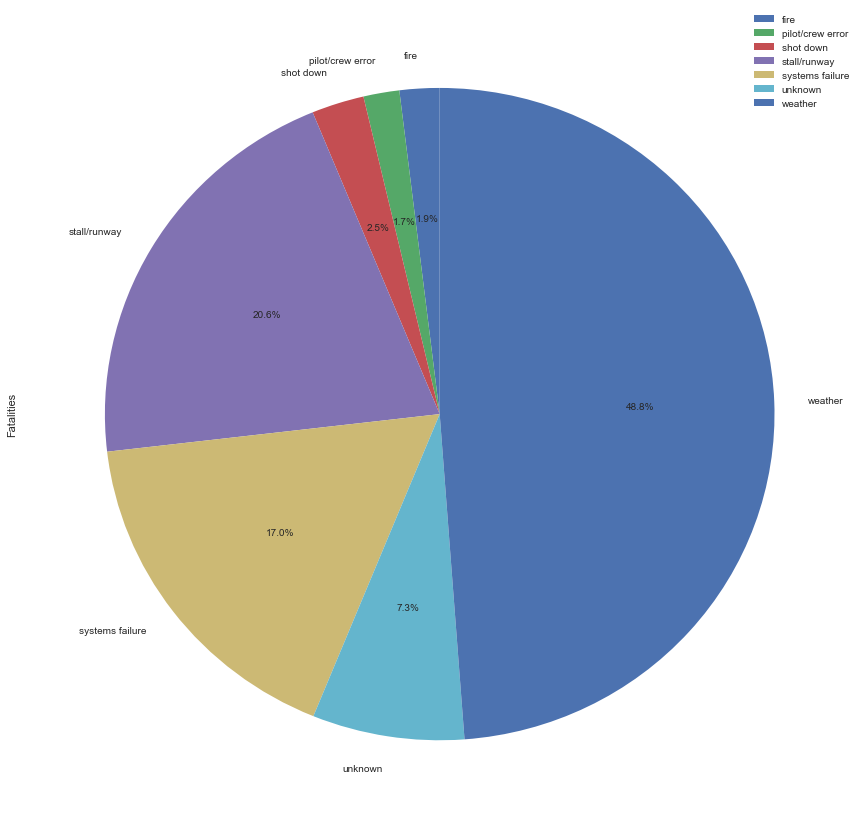

In [75]:
label = df.loc[:,["Fatalities","Label"]].groupby("Label").count()
label.plot.pie(subplots=True, autopct='%1.1f%%', shadow=False, startangle=90, fontsize=10, figsize=(15, 15))

### **Fatalities by Label**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022D64A5F6A0>], dtype=object)

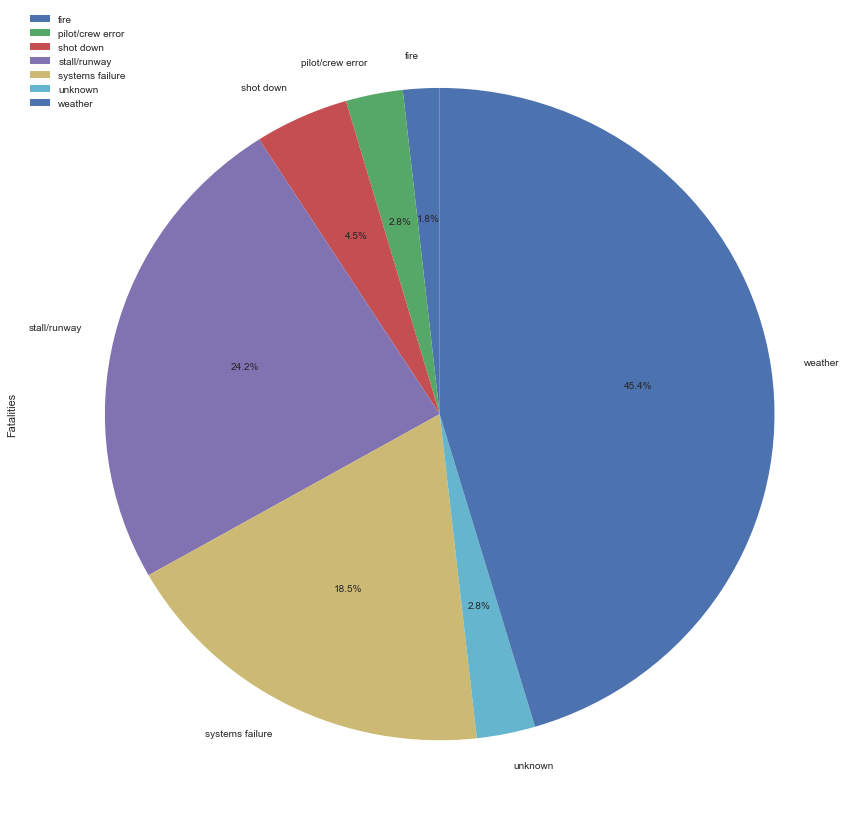

In [79]:
fatalitiesByLabel = df.loc[:,["Fatalities","Label"]].groupby("Label").sum()
fatalitiesByLabel.plot.pie(subplots=True, autopct='%1.1f%%', shadow=False, startangle=90, fontsize=10, figsize=(15, 15))


In [97]:
#Analysis of routes in dataset
routes=df['Route']
routes=routes.dropna().str.lower().str.replace(" ", "").str.split("-")
routes=routes[routes.str.len()==2]
dept2Dest=pd.DataFrame({'Departure': routes.str.get(0), 'Destination': routes.str.get(1)})

### **Most Dangerous City for airplane takeoff**

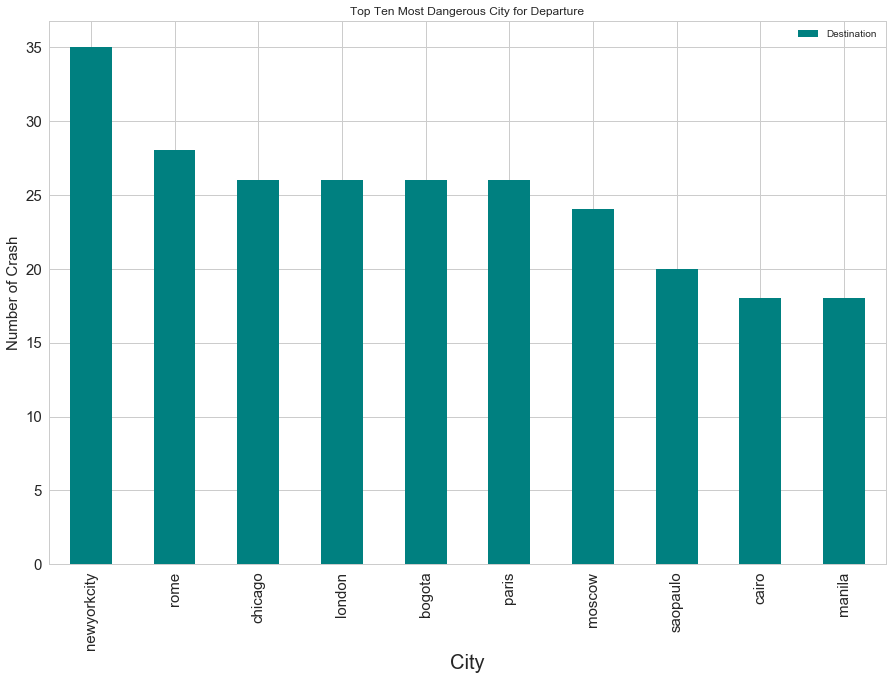

In [94]:
departure = dept2Dest.groupby(['Departure']).count().sort_values(by="Destination", ascending=False).head(10)
plot= departure.plot.bar(figsize=(15,10), title="Top Ten Most Dangerous City for Departure", fontsize=15,color="teal")
plot.set_xlabel("City", fontsize=20)
plot.set_ylabel("Number of Crash", fontsize=15)

### ** Most Dangerous city for Airplane landing**

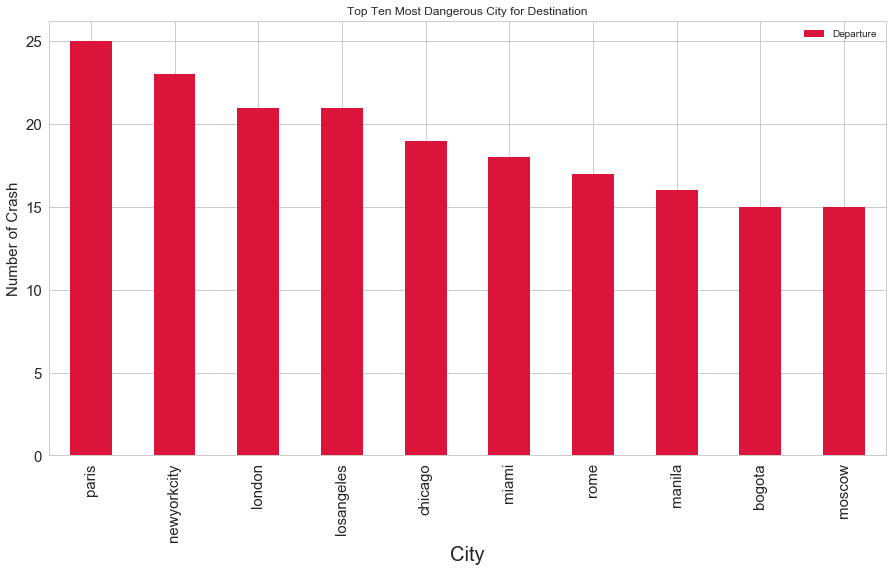

In [103]:
destination = dept2Dest.groupby(['Destination']).count().sort_values(by="Departure", ascending=False).head(10)
plot= destination.plot.bar(figsize=(15,8), title="Top Ten Most Dangerous City for Destination", fontsize=15,color="crimson")
plot.set_xlabel("City", fontsize=20)
plot.set_ylabel("Number of Crash", fontsize=15)

### **Trends observed**

* The Douglas DC-3 aircarft type is the one with the most number of crashes
* Weather and stall/runway are the two major reasons for the crashes of airplanes
* Few of the topmost cities of the world are top ranked destinations for the crashes to occur
* The number of crashes reduced considerably after the year 2000 with the lone exception being 2005